### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [902]:
import requests
import json
import praw
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier, AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, f1_score
from datetime import datetime
import re
import regex
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
URL = "http://www.reddit.com/hot.json"

In [30]:
reddit = praw.Reddit(client_id='oQpDWKR62bbC_g',
                     client_secret='3X7p-nH9G4LS_HC_WG1wW4F96rI',
                     user_agent='my user agent',
                     username='PorkchopDidgeridoo',
                     password='cookies')

print(reddit.read_only)  # Output: False for authorized
                         #         True for read-only

False


In [125]:
#THESE ARE THE FEATURES I SCRAPED FROM THE r/HOT

reddit_dict = {
    'title': [],
    'updoots': [],
    'subreddit': [],
    'subs':[],
    'user_id': [],
    'url': [],
    'comments':[],
    'post_time':[],
    'nsfw':[],
    'spoiler':[],
    'author_un':[]
              }

In [126]:

def get_reddit_data(r_dict):
    for submission in reddit.subreddit('popular').hot(limit=None):
        r_dict['title'].append(submission.title) # Output: the submission's title
        r_dict['updoots'].append(submission.score)  # Output: the submission's score
        r_dict['subreddit'].append(submission.subreddit_name_prefixed)  # Output: the submission's subreddit
        r_dict['subs'].append(submission.subreddit_subscribers)  # Output: the subreddit cubscribers
        r_dict['user_id'].append(submission.id)     # Output: the submittor's ID
        r_dict['url'].append(submission.url)        # Append: the submission's URL
        r_dict['comments'].append(submission.num_comments) #Append: the submission's Comment Count
        r_dict['post_time'].append(datetime.utcfromtimestamp(submission.created_utc)) #Append: When the submission was posted
        r_dict['nsfw'].append(submission.over_18) # NSFW tag
        r_dict['spoiler'].append(submission.spoiler) #Spoiler tag
        r_dict['author_un'].append(submission.author) # Author UserName
        
    return r_dict
    

In [160]:
%%time
df = pd.DataFrame()  

# for x in range(3): #LONG OVERNIGHT SCRAPING SCRIPT
#     reddit_dict = get_reddit_data(reddit_dict)
#     df = pd.concat([df,pd.DataFrame(reddit_dict)],axis=0,ignore_index=True)
#     df.to_csv('updated_reddit.csv')
#     sleep(7200)
    
reddit_dict = get_reddit_data(reddit_dict)
df = pd.concat([df,pd.DataFrame(reddit_dict)],axis=0,ignore_index=True)
df.to_csv('531_1137_reddit.csv')
    
    

Wall time: 1min 33s


In [162]:
%%time
df_morning = pd.read_csv('531_1137_reddit.csv')
df_overnight = pd.read_csv('updated_reddit.csv')

Wall time: 229 ms


In [166]:
df_tot = pd.concat([df_morning,df_overnight],axis=0) #JUST COMBINING MY TWO BIG SCRAPE SETS
df_tot.shape

(57750, 12)

In [174]:
df_unique = df_tot[~df_tot.duplicated(subset=['author_un','title'],keep='last')] #CUTTING OUT DUPES

In [180]:
df_unique['comments'].median()

14.0

In [182]:
df = df_unique

In [186]:
df['target'] = [1 if x > 38 else 0 for x in df['comments']]

C:\Users\Johnny\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [203]:
df['post_time'][17332][-8:-3]

'13:48'

In [214]:
#Making a decimal value time posted column

new_time_lst = []
for x in df['post_time']:
    new_time_lst.append(int(x[-8:-6]) + int(x[-5:-3])/60)

In [217]:
df.loc[:,'dec_post_time'] = new_time_lst # Assigning it

C:\Users\Johnny\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [249]:
df['url'][17332].split('//')[1].split('/')

['cnbc.com', 'id', '105241999']

In [256]:
df_1 = df.copy()

In [257]:
domain = [] #GET the domain down to a usable length
for x in df_1['url']:
    domain.append(x.split('//')[1].split('/')[0])
    
df_1['domain'] = domain

In [1125]:
df = pd.read_csv('cleaned_df.csv')
df['time_int'] = [int(x) for x in df['dec_post_time']] # make in integer level time columns
df = df[df['comments']<2000].copy()
df['target'] = [1 if x > 38 else 0 for x in df['comments']] # 75%
df.reset_index(drop=True,inplace=True)

In [1126]:
def title_cleaner(title):
    p_stem = PorterStemmer()
    # 1. Kill all punctuation
    no_punc = regex.sub('[\p{P}]', '', title)
    #
    # 2. Convert to lower case, split into individual words
    words = no_punc.lower().split()
    #
    # 3. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words('english'))
    # 
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #
    stemmed = [p_stem.stem(x) for x in meaningful_words]
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    
    return " ".join(meaningful_words)

# THIS CELL SETS YOUR FEATURES YO!

In [1127]:
dummy = ['subreddit','domain' ]#'subreddit','domain'
tf_features = ['nsfw','spoiler' ]#'nsfw','spoiler'
features = ['subs','dec_post_time']#subs','dec_post_time','time_int'
nlp ='title'#'title'
target = 'target'

In [1128]:
def make_final_df_and_target(df,dum_list,tf_features,feature_list,nlp_list, target, max_features):
    '''
    Takes in Dataframe and lists of features to alter and returns an X, y
    
    df: dataframe to pull from
    
    dum_list: list of features you want to one hot encode
    
    tf_features: features already in True/False format
    
    feature_list: list of numeric features ready for modeling
    
    nlp_list: list of features that you want to use NLP on 
    
    target: column name of your target variable
    
    Thanks for reading the documentation ya filthy animal ;)
    '''
    y = df[target]
    X = pd.DataFrame()
    X = df[feature_list].copy()
    
    X[feature_list] = df[feature_list].astype(float).copy() # Feature List copy over
    
    X[tf_features] = df[tf_features].astype(int).copy() # Binary the True/False cols
    
    X[dummy] = df[dummy]
    X = pd.get_dummies(X, columns=dummy, drop_first=True, prefix=None) #Set Dummies
    
    X['title_len'] = [len(x.split()) for x in df['title']]
    
    df[nlp] = [title_cleaner(x) for x in df[nlp]]
    
    vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = max_features) 

#     # fit_transform() does two functions: First, it fits the model
#     # and learns the vocabulary; second, it transforms our training data
#     # into feature vectors. The input to fit_transform should be a list of 
#     # strings.
    train_data_features = vectorizer.fit_transform(df[nlp])

    vector_df = pd.DataFrame(data=train_data_features.toarray(), columns = vectorizer.get_feature_names())

    
    X = pd.concat([X,vector_df], axis = 1)
#     print(X.shape)
    
#     tvec = TfidfVectorizer()
#     tvec.fit_transform(df[nlp])
    
#     tvec_df  = pd.DataFrame(tvec.toarray(), columns=tvec.get_feature_names())
    
    return X, y
    
    

In [1130]:
X, y = make_final_df_and_target(df,dummy,tf_features, features, nlp, target, max_features=800)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=666)
X.head()

(11025, 4017)


AttributeError: 'TfidfVectorizer' object has no attribute 'todense'

In [941]:
# %%time

# gamma_range = np.logspace(-5, 2, 10)
# C_range = np.logspace(-3, 2, 10)
# kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

# param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)

# clf = svm.SVC() # Support vector classifier
# grid = GridSearchCV(clf, param_grid=param_grid, cv=5,scoring='accuracy',verbose=1, n_jobs=-1)
# grid.fit(X_train,y_train)


# print(grid.score(X_test, y_test))


In [947]:
%%time
lr_pipe = Pipeline([
    ('ss',StandardScaler()),
    ('logreg',LogisticRegression())])

lr_params = {
    'logreg__penalty': ['l1','l2'], 
    'logreg__C': [0.01,0.06,1]
}
    
gs = GridSearchCV(lr_pipe, param_grid=lr_params,verbose=1, n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.score(X_train,y_train))
print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   34.1s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   41.3s finished


0.7663146493365828
0.7544002166260493
{'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Wall time: 44.7 s


In [948]:
%%time
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [2,3,4,5,6,7,10,20,30,40],
    'max_features': [1,2,3],
    'max_depth': [None,7,8,9,10]
    
}
gs = GridSearchCV(rf, param_grid=rf_params, verbose=1,n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.score(X_train,y_train))
print(gs.score(X_test,y_test))
print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.3min finished


0.999458434876794
0.7609233305853257
0.7608989981045221
{'max_depth': None, 'max_features': 3, 'n_estimators': 40}
Wall time: 1min 21s


In [944]:
%%time
bag = BaggingClassifier(random_state=666)
bag_params = {
    'n_estimators': range(1,20)    
}

gs = GridSearchCV(bag, param_grid=bag_params,verbose = 1, n_jobs = -1)
gs.fit(X_train, y_train)
print(gs.score(X_train,y_train))
print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  2.7min finished


0.97143243975088
0.7592743027349039
{'n_estimators': 10}
Wall time: 3min


In [945]:
%%time
gb = GradientBoostingClassifier()
gb_params = {
    'max_depth': [ 3,4,5],
    'n_estimators': [90, 100, 110],
    'max_features': ['auto', None]
}
gs_gb = GridSearchCV(gb, param_grid=gb_params, verbose=1,n_jobs=-1)
gs_gb.fit(X_train,y_train)
print(gs_gb.score(X_train, y_train))
print(gs_gb.score(X_test, y_test))
print(gs_gb.best_score_)
print(gs_gb.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.3min finished


0.8069320335770377
0.7752129705963177
0.7791768210127268
{'max_depth': 4, 'max_features': None, 'n_estimators': 100}
Wall time: 4min 55s


,time_int
0,12.0
1,13.0
2,12.0
3,12.0
4,13.0


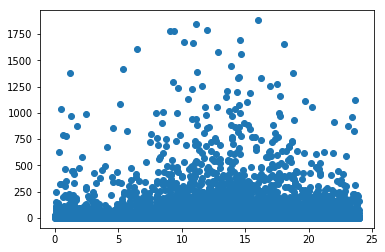

In [808]:
plt.scatter(df['dec_post_time'], df['comments'])

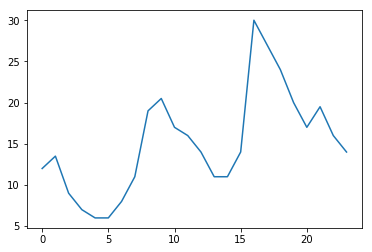

In [985]:
plt.plot(df.groupby('time_int')['comments'].median())

In [1039]:
(df['subreddit'].value_counts() > 33)['r/EarthPorn']

True

In [1040]:
df['active_sub']=[(df['subreddit'].value_counts() > 33)[x] for x in df['subreddit']]

In [1054]:
col_1_df = pd.DataFrame(df[df['active_sub']==True].groupby('subreddit')['comments'].median().sort_values(ascending=False))

In [1056]:
col_2_df = pd.DataFrame(df[df['active_sub']==True].groupby('subreddit')['comments'].mean().sort_values(ascending=False))

In [1066]:
col_3 = pd.DataFrame(df[df['active_sub']==True].groupby('subreddit')['subs'].mean())


In [2]:
df_subs= pd.concat(objs=[col_1_df,col_2_df,col_3], axis = 1)
df_subs.set_axis(['Comments Median', 'Comments Mean', 'Subreddit Subscribers'], axis = 1, inplace=True)
df_subs = df_subs.sort_values('Comments Mean', ascending=False).copy()

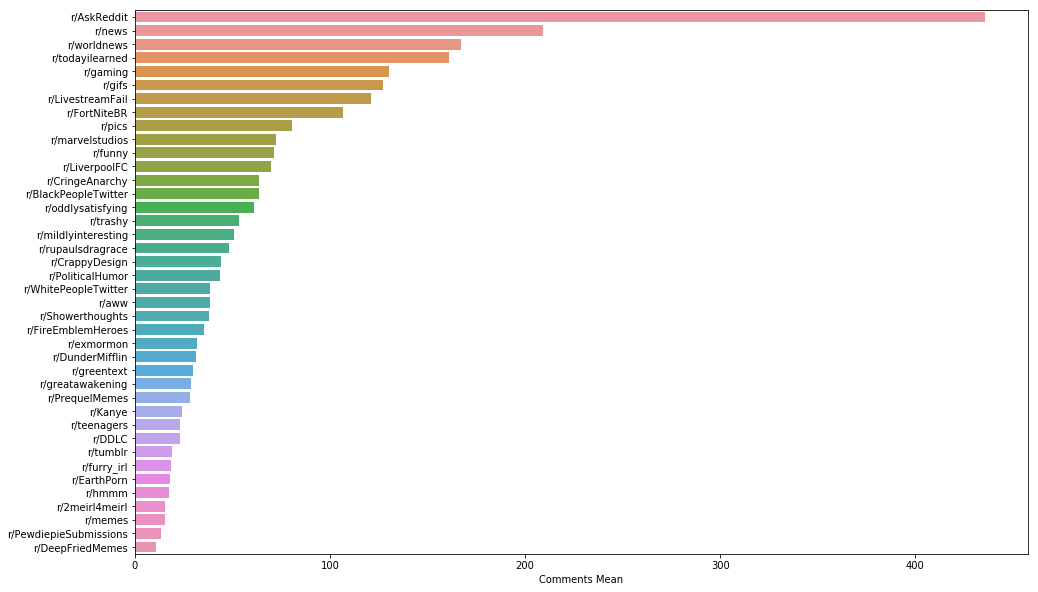

In [1120]:
fig, ax = plt.subplots(figsize = (16,10))
ax = sns.barplot(x=df_subs['Comments Mean'], y = df_subs.index, orient='h')


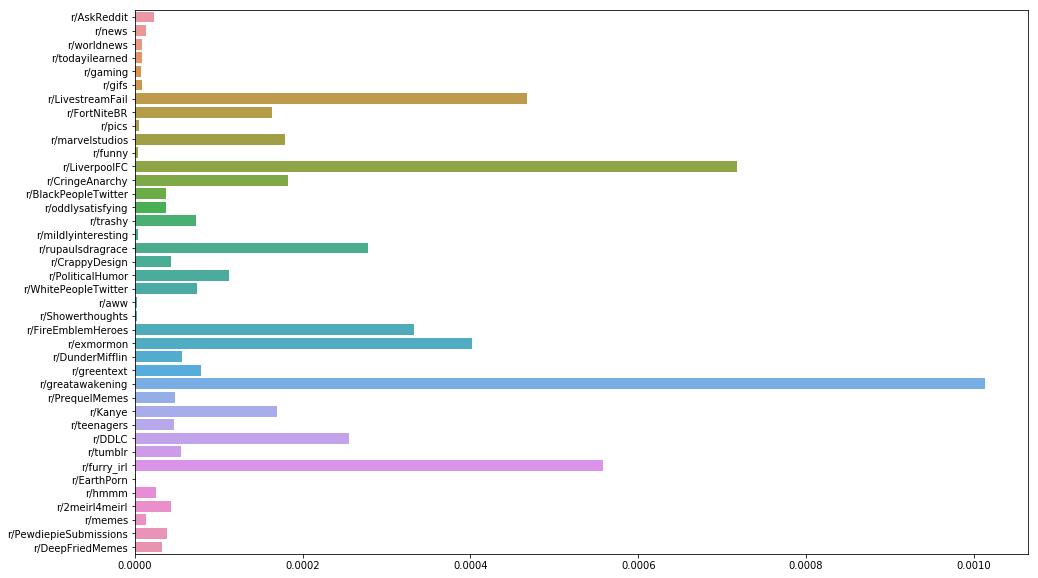

In [1121]:
fig, ax = plt.subplots(figsize = (16,10))
ax = sns.barplot(x=df_subs['Comments Mean']/df_subs['Subreddit Subscribers'], y = df_subs.index, orient='h')


In [977]:
((df['target']==1) & df['spoiler']).sum()/ sum(df['spoiler']) # % pos that are spoiler

0.7345132743362832

In [1124]:
((df['target']==1) & df['nsfw']).sum()/ sum(df['nsfw'])# % pos that are NSFW

0.23893805309734514